In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle
import time
import random

In [2]:
DATA_SET = 'both_indep'
# load data
# data = np.load(f'preprocessed/IMWUT_OnHW-chars_dataset_2020-09-22/{DATA_SET}.pkl', allow_pickle=True)
# set global variables
LOG = True
SAMPLE_LENGTH = 64 # resampled to 64 in preprocessing.ipynb
N_CHANNELS = 13
CLASSES = 54 # in the case of 'both' lower and upper case.
if DATA_SET.__contains__('lower') or DATA_SET.__contains__('upper'):
    CLASSES = 26 # in the case of 'lower' or 'upper' case.


In [3]:
MAX_ACC_FRONT = 32768
MAX_GYR = 32768
MAX_ACC_BACK = 8192
MAX_MAG = 8192
MAX_FORCE = 4096

DESIRED_SAMPLE_LENGTH = SAMPLE_LENGTH

def log(o):
    if LOG:
        print(o)

################# util functions #############
def bounds(xs):
    maxs = []
    mins = []
    for k in range(13):
        maxs.append(0)
        mins.append(0)
    for i in range(len(xs)):
        # per item
        for j in range(len(xs[i])):
            # per timestamp
            for k in range(13):
                x = xs[i][j][k]
                if x > maxs[k]:
                    maxs[k] = x
                if x < mins[k]:
                    mins[k] = x
    return mins, maxs

def log_bounds(xs):
    if LOG:
        log(f'min and max per channel: {list(zip(*bounds(xs)))}')


def plot(data, labels, n_ex, n_channels):
    if LOG:
        plt.figure(figsize=(n_ex*5, 20*n_channels/N_CHANNELS)) # dimensions of the plot in inches
        for i in range(n_ex):
            channels = [] # sensor channels
            for k in range(n_channels):
                channels.append([])
                for j in range(len(data[i])):
                    channels[k].append(data[i][j][k])
            for k in range(n_channels):
                plt.subplot(n_channels, n_ex, n_ex*k+i+1)
                plt.plot(channels[k])
            plt.title(labels[i])
        plt.show()

def load_data(data_set):
    with open(f'preprocessed/{data_set}.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
def shuffle_data(data):

    log(type(data))
    x_train, y_train, x_test, y_test = data[0]
    x = np.concatenate((x_test, x_train), axis=0)
    y = np.concatenate((y_test, y_train), axis=0)
    indices = np.array(range(len(x)))
    np.random.shuffle(indices)
    x_shuffled = np.array([x[i] for i in indices])
    y_shuffled = np.array([y[i] for i in indices])

    cuts = [round(len(x)*i*0.2) for i in range(0,6)]
    log(cuts)
    log(len(x))
    data_shuffled = []
    for i in range(len(data)):
        x_train = np.concatenate((x_shuffled[:cuts[i]], x_shuffled[cuts[i+1]:]), axis=0)
        y_train = np.concatenate((y_shuffled[:cuts[i]], y_shuffled[cuts[i+1]:]), axis=0)
        x_test = x_shuffled[cuts[i]:cuts[i+1]]
        y_test = y_shuffled[cuts[i]:cuts[i+1]]
        data_shuffled.append((x_train, y_train, x_test, y_test))
    return data_shuffled


if 'dep' in DATA_SET and not 'indep' in DATA_SET:
    data = load_data(f'{DATA_SET[:-3]}indep')
    data = shuffle_data(data)
else:
    data = load_data(DATA_SET)

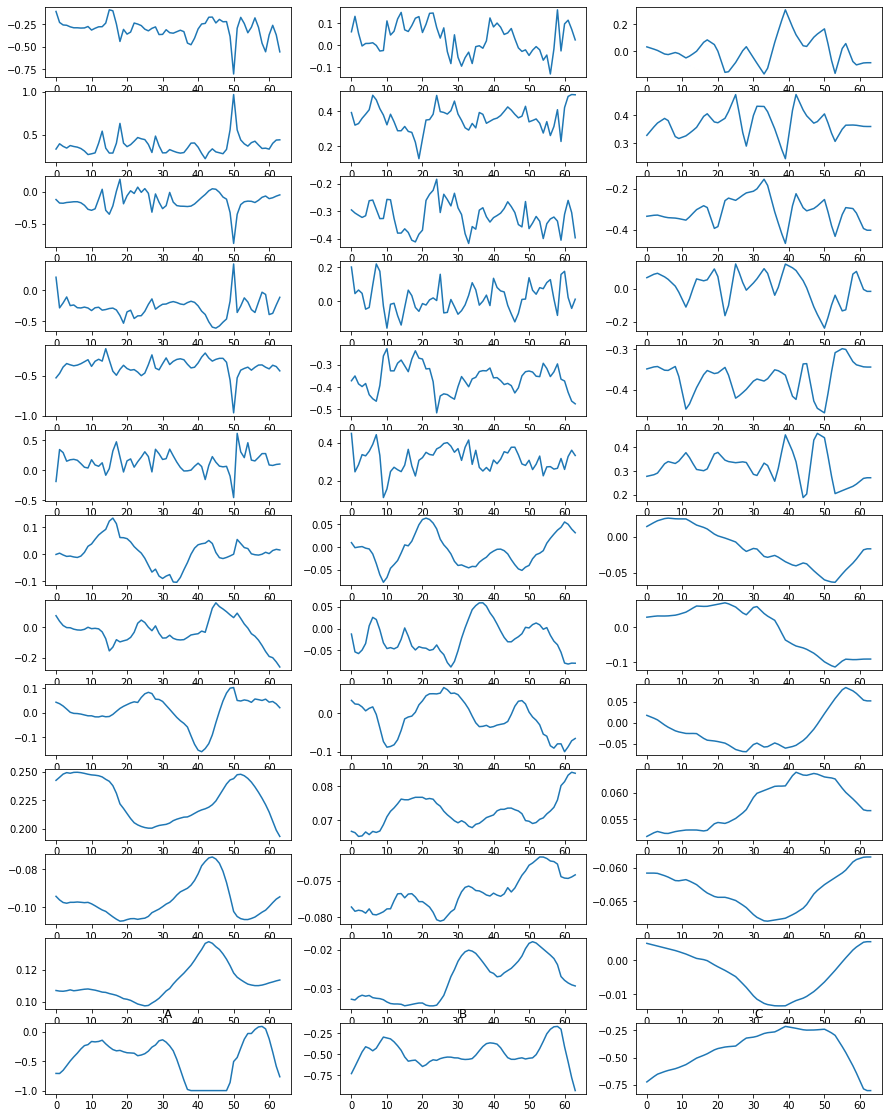

5


In [5]:
plot(data[0][0], data[0][1], 3, N_CHANNELS)
folds = data
log(len(folds))

In [6]:
ys = folds[0][3]
vocab = sorted(set(ys.reshape(ys.shape[0])))
log(f'data vocab: {vocab}')

ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None, num_oov_indices=0)
log(f'keras vocab: {ids_from_chars.get_vocabulary()}')
log(f'keras vocab ids: {ids_from_chars(ids_from_chars.get_vocabulary())}')


data vocab: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
keras vocab: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
keras vocab ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]


In [7]:
# training on one fold
def train_fold(fold_index, lr, epochs, ):
    fold = folds[fold_index]
    xtrain, ytrain, xtest, ytest = fold

    chars_train = ytrain.copy()
    chars_test = ytest.copy()

    ids_train = ids_from_chars(chars_train)
    ids_test = ids_from_chars(chars_test)
    log((len(ids_train), len(ids_test)))

    labels_train = np.array(ids_train).reshape((-1,1))
    labels_test = np.array(ids_test).reshape((-1,1))

    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.4))
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(CLASSES, activation='softmax'))

    # model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'],
                  )
    history = model.fit(xtrain, labels_train, epochs=epochs, validation_data=(xtest, labels_test))

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    print({'learning rate': lr,
           'epochs': epochs,
           'Max acc': max(history.history['accuracy']),
           'Max val_acc': max(history.history['val_accuracy'])})
    plt.show()
    return {'learning rate': lr,
          'epochs': epochs,
           'max_accuracy': max(history.history['accuracy']),
           'max_val_accuracy': max(history.history['val_accuracy'])}


(23316, 7956)
Epoch 1/20
729/729 [==============================] - 36s 32ms/step - loss: 3.6838 - accuracy: 0.0468 - val_loss: 2.9531 - val_accuracy: 0.1498
Epoch 2/20
729/729 [==============================] - 20s 27ms/step - loss: 2.8770 - accuracy: 0.1712 - val_loss: 2.2934 - val_accuracy: 0.2922
Epoch 3/20
729/729 [==============================] - 20s 27ms/step - loss: 2.4115 - accuracy: 0.2739 - val_loss: 1.9083 - val_accuracy: 0.3998
Epoch 4/20
729/729 [==============================] - 20s 28ms/step - loss: 2.0598 - accuracy: 0.3772 - val_loss: 1.6317 - val_accuracy: 0.4830
Epoch 5/20
729/729 [==============================] - 20s 28ms/step - loss: 1.7820 - accuracy: 0.4560 - val_loss: 1.4092 - val_accuracy: 0.5343
Epoch 6/20
729/729 [==============================] - 20s 27ms/step - loss: 1.5738 - accuracy: 0.5053 - val_loss: 1.3591 - val_accuracy: 0.5415
Epoch 7/20
729/729 [==============================] - 20s 28ms/step - loss: 1.4645 - accuracy: 0.5284 - val_loss: 1.2645 -

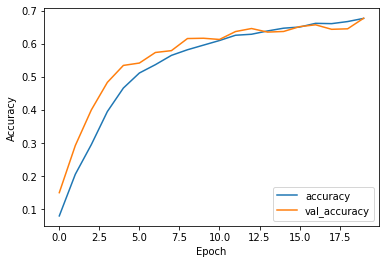

(23682, 7590)
Epoch 1/20
741/741 [==============================] - 32s 30ms/step - loss: 3.7225 - accuracy: 0.0485 - val_loss: 2.9843 - val_accuracy: 0.1456
Epoch 2/20
741/741 [==============================] - 20s 27ms/step - loss: 2.9005 - accuracy: 0.1564 - val_loss: 2.4650 - val_accuracy: 0.2642
Epoch 3/20
741/741 [==============================] - 20s 27ms/step - loss: 2.4249 - accuracy: 0.2642 - val_loss: 2.1180 - val_accuracy: 0.3783
Epoch 4/20
741/741 [==============================] - 20s 27ms/step - loss: 2.0869 - accuracy: 0.3571 - val_loss: 1.8319 - val_accuracy: 0.4540
Epoch 5/20
741/741 [==============================] - 20s 27ms/step - loss: 1.7996 - accuracy: 0.4398 - val_loss: 1.6132 - val_accuracy: 0.5101
Epoch 6/20
741/741 [==============================] - 20s 27ms/step - loss: 1.5747 - accuracy: 0.4959 - val_loss: 1.4938 - val_accuracy: 0.5404
Epoch 7/20
741/741 [==============================] - 20s 28ms/step - loss: 1.4707 - accuracy: 0.5275 - val_loss: 1.4299 -

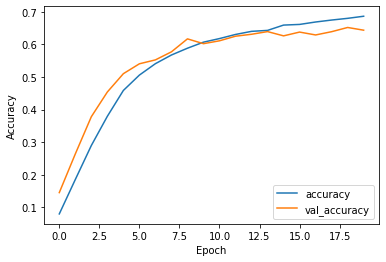

(23731, 7541)
Epoch 1/20
742/742 [==============================] - 31s 30ms/step - loss: 3.6456 - accuracy: 0.0543 - val_loss: 3.0159 - val_accuracy: 0.1426
Epoch 2/20
742/742 [==============================] - 20s 27ms/step - loss: 2.8737 - accuracy: 0.1592 - val_loss: 2.4891 - val_accuracy: 0.2618
Epoch 3/20
742/742 [==============================] - 20s 27ms/step - loss: 2.4211 - accuracy: 0.2753 - val_loss: 2.1087 - val_accuracy: 0.3690
Epoch 4/20
742/742 [==============================] - 20s 27ms/step - loss: 2.0389 - accuracy: 0.3787 - val_loss: 1.8202 - val_accuracy: 0.4434
Epoch 5/20
742/742 [==============================] - 20s 27ms/step - loss: 1.7398 - accuracy: 0.4533 - val_loss: 1.5820 - val_accuracy: 0.5144
Epoch 6/20
742/742 [==============================] - 20s 27ms/step - loss: 1.5457 - accuracy: 0.5076 - val_loss: 1.5074 - val_accuracy: 0.5327
Epoch 7/20
742/742 [==============================] - 20s 27ms/step - loss: 1.4273 - accuracy: 0.5393 - val_loss: 1.4147 -

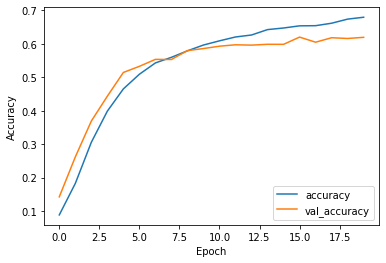

(23919, 7353)
Epoch 1/20
748/748 [==============================] - 32s 30ms/step - loss: 3.6367 - accuracy: 0.0558 - val_loss: 3.1051 - val_accuracy: 0.1291
Epoch 2/20
748/748 [==============================] - 20s 27ms/step - loss: 2.7692 - accuracy: 0.1866 - val_loss: 2.7081 - val_accuracy: 0.2391
Epoch 3/20
748/748 [==============================] - 21s 28ms/step - loss: 2.2940 - accuracy: 0.2993 - val_loss: 2.3714 - val_accuracy: 0.3264
Epoch 4/20
748/748 [==============================] - 20s 27ms/step - loss: 1.9709 - accuracy: 0.3875 - val_loss: 2.1613 - val_accuracy: 0.3860
Epoch 5/20
748/748 [==============================] - 21s 28ms/step - loss: 1.6983 - accuracy: 0.4625 - val_loss: 1.9647 - val_accuracy: 0.4421
Epoch 6/20
748/748 [==============================] - 21s 28ms/step - loss: 1.4770 - accuracy: 0.5296 - val_loss: 1.8580 - val_accuracy: 0.4706
Epoch 7/20
748/748 [==============================] - 21s 27ms/step - loss: 1.3465 - accuracy: 0.5609 - val_loss: 1.7999 -

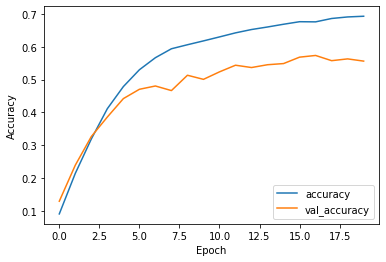

(23212, 8060)
Epoch 1/20
726/726 [==============================] - 32s 32ms/step - loss: 3.6812 - accuracy: 0.0561 - val_loss: 2.7437 - val_accuracy: 0.1850
Epoch 2/20
726/726 [==============================] - 20s 28ms/step - loss: 2.7606 - accuracy: 0.1902 - val_loss: 2.1813 - val_accuracy: 0.3241
Epoch 3/20
726/726 [==============================] - 20s 28ms/step - loss: 2.3286 - accuracy: 0.2981 - val_loss: 1.8111 - val_accuracy: 0.4329
Epoch 4/20
726/726 [==============================] - 20s 28ms/step - loss: 1.9766 - accuracy: 0.3993 - val_loss: 1.5434 - val_accuracy: 0.5091
Epoch 5/20
726/726 [==============================] - 20s 28ms/step - loss: 1.7110 - accuracy: 0.4668 - val_loss: 1.4734 - val_accuracy: 0.5196
Epoch 6/20
726/726 [==============================] - 20s 28ms/step - loss: 1.5456 - accuracy: 0.5166 - val_loss: 1.3646 - val_accuracy: 0.5480
Epoch 7/20
726/726 [==============================] - 20s 28ms/step - loss: 1.4323 - accuracy: 0.5450 - val_loss: 1.2372 -

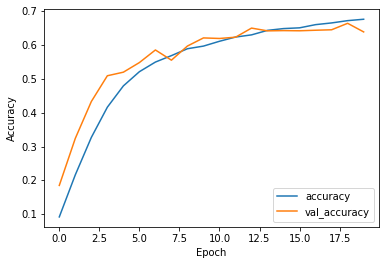

total time needed to perform training for all folds: 2090.4891176223755
results: [{'learning rate': 0.001, 'epochs': 20, 'max_accuracy': 0.6764453649520874, 'max_val_accuracy': 0.6768476366996765}, {'learning rate': 0.001, 'epochs': 20, 'max_accuracy': 0.6862173676490784, 'max_val_accuracy': 0.6517786383628845}, {'learning rate': 0.001, 'epochs': 20, 'max_accuracy': 0.6794488430023193, 'max_val_accuracy': 0.6200768947601318}, {'learning rate': 0.001, 'epochs': 20, 'max_accuracy': 0.6934236288070679, 'max_val_accuracy': 0.5737794041633606}, {'learning rate': 0.001, 'epochs': 20, 'max_accuracy': 0.676029622554779, 'max_val_accuracy': 0.6640198230743408}]
averages: {'max_accuracy': 0.6823129653930664, 'max_val_accuracy': 0.6373004794120789}


In [8]:
LOG = True
lr = 0.001
epochs = 20
results = []
start = time.time()
for i in range(len(folds)):
    results.append(train_fold(i, lr, epochs))
end = time.time()
log(f'total time needed to perform training for all folds: {end-start}')
log(f'results: {results}')
averages = {'max_accuracy': 0, 'max_val_accuracy': 0}
for i in range(len(results)):
    averages['max_accuracy'] += results[i]['max_accuracy']/len(results)
    averages['max_val_accuracy'] += results[i]['max_val_accuracy']/len(results)
log(f'averages: {averages}')